# Eddy detection around aghulas current

## Import modules & initialisation

In [110]:
# import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy 
from tuto_tools import *
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture

import seaborn as sns
import intake


## Definition des fonctions 

In [111]:
# Def fonctions 
def create_map(extent=[0,45, -45, -25]): # on choisit ici les coordonnées de la zone
    fig = plt.figure(figsize=(12,4),dpi=200)
    proj = ccrs.PlateCarree()
    ax = fig.add_axes([0,0,1,1],projection=proj)
    ax.set_extent(extent, crs=proj)
    gl=ax.gridlines(crs=proj, draw_labels=True,
        linewidth=0.5, color=[0.6]*3, alpha=0.5, linestyle='--')
    # gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/10+1))
    # gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/5+1))
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/30+1))
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/20+1))
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor=[0.7]*3)
    ax.add_feature(cfeature.COASTLINE)
    return fig, proj, ax

## Parameters & Data

In [112]:
# Ouverture data
ds = xr.open_zarr('DATA/GLOB_HOMOGENEOUS_variables.zarr')
ds = ds.where(ds.LONGITUDE < 45, drop=True)
ds = ds.where(ds.LONGITUDE > 0, drop=True)
ds = ds.where(ds.LATITUDE < -25, drop=True)
ds = ds.where(ds.LATITUDE > -45, drop=True) 

In [113]:
# Definition des paramètres du problème
maxvar=99.8

In [114]:
# Selection d'une certaine partie des données : entre 0 et 1400m
dsub = ds.sel(DEPTH=slice(0,-1400))

# Np profiles with Nz depth levels.

X = dsub['TEMP'].values
depth = dsub['DEPTH'].values
lon = dsub['LONGITUDE'].values
lat = dsub['LATITUDE'].values
temp = dsub['TEMP'].values
time = dsub['TIME'].values
# Size of the training set X:
[Np, Nz] = X.shape # Create the array X(Nz,Np)
print("Number of raw features (Depth Levels): ", Nz)
print("Number of samples (N profiles): ", Np)

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)
Xn = scaler.transform(X)  

# Compute P (the EOFs) from x:
reducer = PCA(n_components=maxvar/100,svd_solver='full')
reducer.fit(Xn)

# Reduce the dataset (compute the y):
Xr = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

print(Xr.shape)

Number of raw features (Depth Levels):  281
Number of samples (N profiles):  3600
(3600, 10)


## Clustering with GMM

In [115]:
from sklearn.mixture import GaussianMixture as GMM
# Parametres
n_clusters = 4 #nombre de cluster à chercher

# Create classifier:
gmm = GMM(n_components=n_clusters, random_state=0)

# Train it:
gmm.fit(Xr)

# Classify data:
labels = gmm.predict(Xr)
 
n_clusters_ = gmm.n_components

Text(0.5, 1.0, 'True 4 cluster labels')

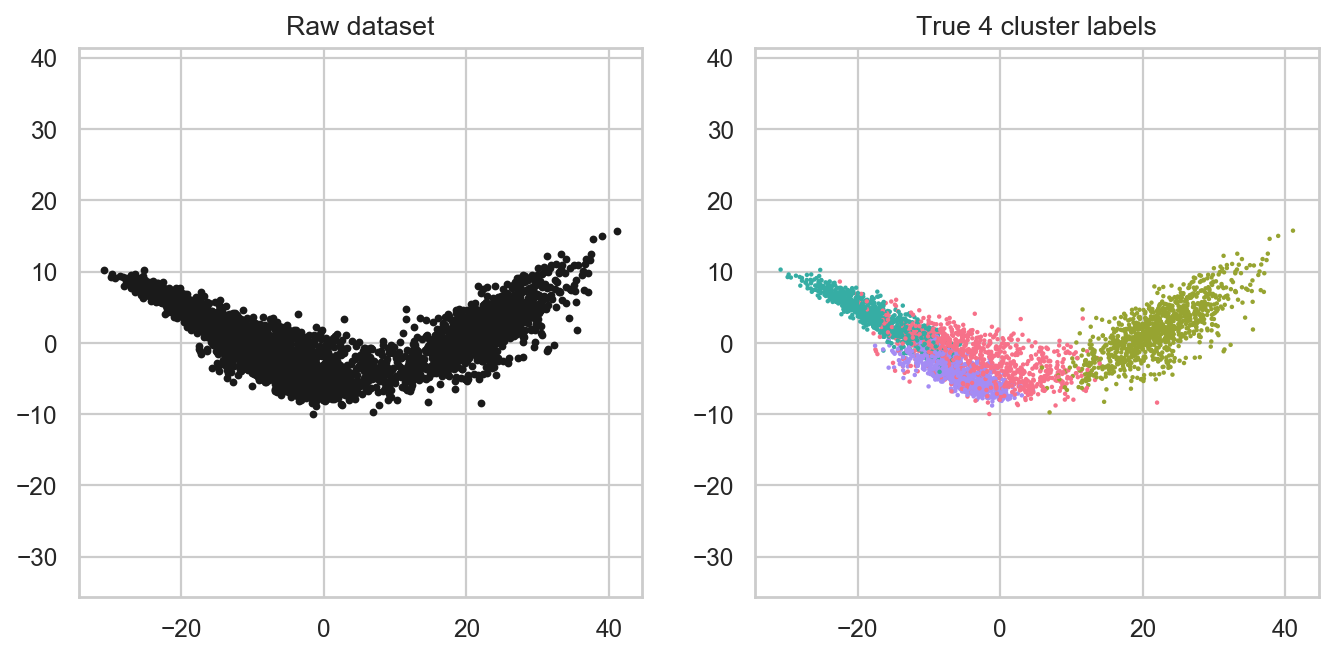

In [116]:
# Plot the dummy dataset
plt.figure(figsize=(10,10), dpi=160, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.plot(Xr[:, 0], Xr[:, 1],'k.',markersize=5)
plt.axis('equal')
plt.title("Raw dataset")
plt.subplot(222)
plt.scatter(Xr[:, 0], Xr[:, 1],1,labels, cmap=ListedColormap(sns.husl_palette(n_clusters).as_hex()))
plt.axis('equal')
plt.title("True %i cluster labels"%n_clusters)


# Profil moyen de chaque cluster dans l'espace réduit

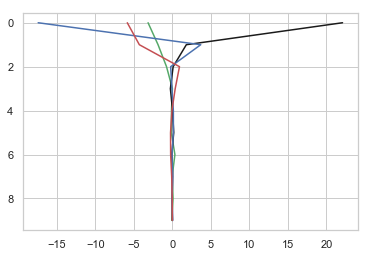

In [117]:
plt.plot(gmm.means_[0,:],range((np.shape(gmm.means_))[1]),"g")
plt.plot(gmm.means_[1,:],range((np.shape(gmm.means_))[1]),"k")
plt.plot(gmm.means_[2,:],range((np.shape(gmm.means_))[1]),"b")
plt.plot(gmm.means_[3,:],range((np.shape(gmm.means_))[1]),"r")
plt.gca().invert_yaxis()


## Profil moyen des cluster dans l'espace réel

In [118]:
# Ici, on recup les temperatures de chacuns des clusters dans les tab class0, class1, class2.

class0 = np.zeros((sum(labels == 0),len(X[2])))
class1 = np.zeros((sum(labels == 1),len(X[2])))
class2 = np.zeros((sum(labels == 2),len(X[2])))
class3 = np.zeros((sum(labels == 3),len(X[2])))

lon0 = np.zeros(sum(labels == 0))
lon1 = np.zeros(sum(labels == 1))
lon2 = np.zeros(sum(labels == 2))
lon3 = np.zeros(sum(labels == 3))

lat0 = np.zeros(sum(labels == 0))
lat1 = np.zeros(sum(labels == 1))
lat2 = np.zeros(sum(labels == 2))
lat3 = np.zeros(sum(labels == 3))

k=0; s=0; w=0; z=0
for i in range(len(labels)):
    if labels[i] == 0:
        class0[k]=X[i,:]
        lon0[k]=lon[i] 
        lat0[k]=lat[i]
        k=k+1
    elif labels[i] == 1:
        class1[s]=X[i,:]
        lon1[s]=lon[i] 
        lat1[s]=lat[i]
        s=s+1
    elif labels[i] == 2:
        class2[w]=X[i,:]
        lon2[w]=lon[i] 
        lat2[w]=lat[i]
        w=w+1
    elif labels[i] == 3:
        class3[z]=X[i,:]
        lon3[z]=lon[i] 
        lat3[z]=lat[i]
        z=z+1
        
# nb d'elements dans chaque cluster    
print(k,s,w,z)    

885 1029 882 804


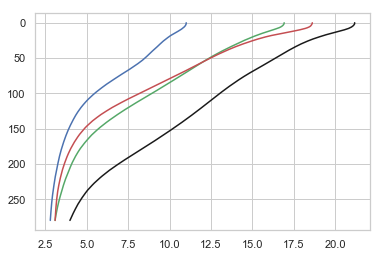

In [119]:
# On regarde la tête des courbes "caractéristiques" des différents clusters obtenus
plt.plot(np.mean(class0,axis=0),range(0,281),'g')
plt.plot(np.mean(class1,axis=0),range(0,281),'k')
plt.plot(np.mean(class2,axis=0),range(0,281),'b')
plt.plot(np.mean(class3,axis=0),range(0,281),'r')
plt.gca().invert_yaxis()

# Moyenne et ecart-type associé
### +/-1 std == 68%

Text(0, 0.5, "Depth N° d'echantillon")

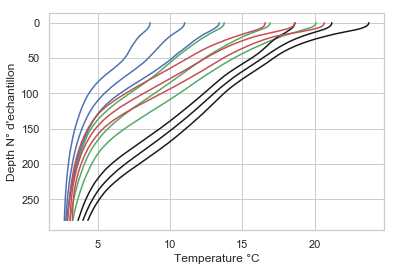

In [120]:
plt.plot(np.mean(class0,axis=0),range(0,281),'g')
plt.plot(np.mean(class0,axis=0)+np.std(class0,axis=0),range(0,281),'g')
plt.plot(np.mean(class0,axis=0)-np.std(class0,axis=0),range(0,281),'g')

plt.plot(np.mean(class1,axis=0),range(0,281),'k')
plt.plot(np.mean(class1,axis=0)+np.std(class1,axis=0),range(0,281),'k')
plt.plot(np.mean(class1,axis=0)-np.std(class1,axis=0),range(0,281),'k')

plt.plot(np.mean(class2,axis=0),range(0,281),'b')
plt.plot(np.mean(class2,axis=0)+np.std(class2,axis=0),range(0,281),'b')
plt.plot(np.mean(class2,axis=0)-np.std(class2,axis=0),range(0,281),'b')

plt.plot(np.mean(class3,axis=0),range(0,281),'r')
plt.plot(np.mean(class3,axis=0)+np.std(class3,axis=0),range(0,281),'r')
plt.plot(np.mean(class3,axis=0)-np.std(class3,axis=0),range(0,281),'r')

plt.gca().invert_yaxis()
plt.xlabel("Temperature °C")
plt.ylabel("Depth N° d'echantillon")



# Carte de la distrubution des Clusters

/home/clems/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
/home/clems/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


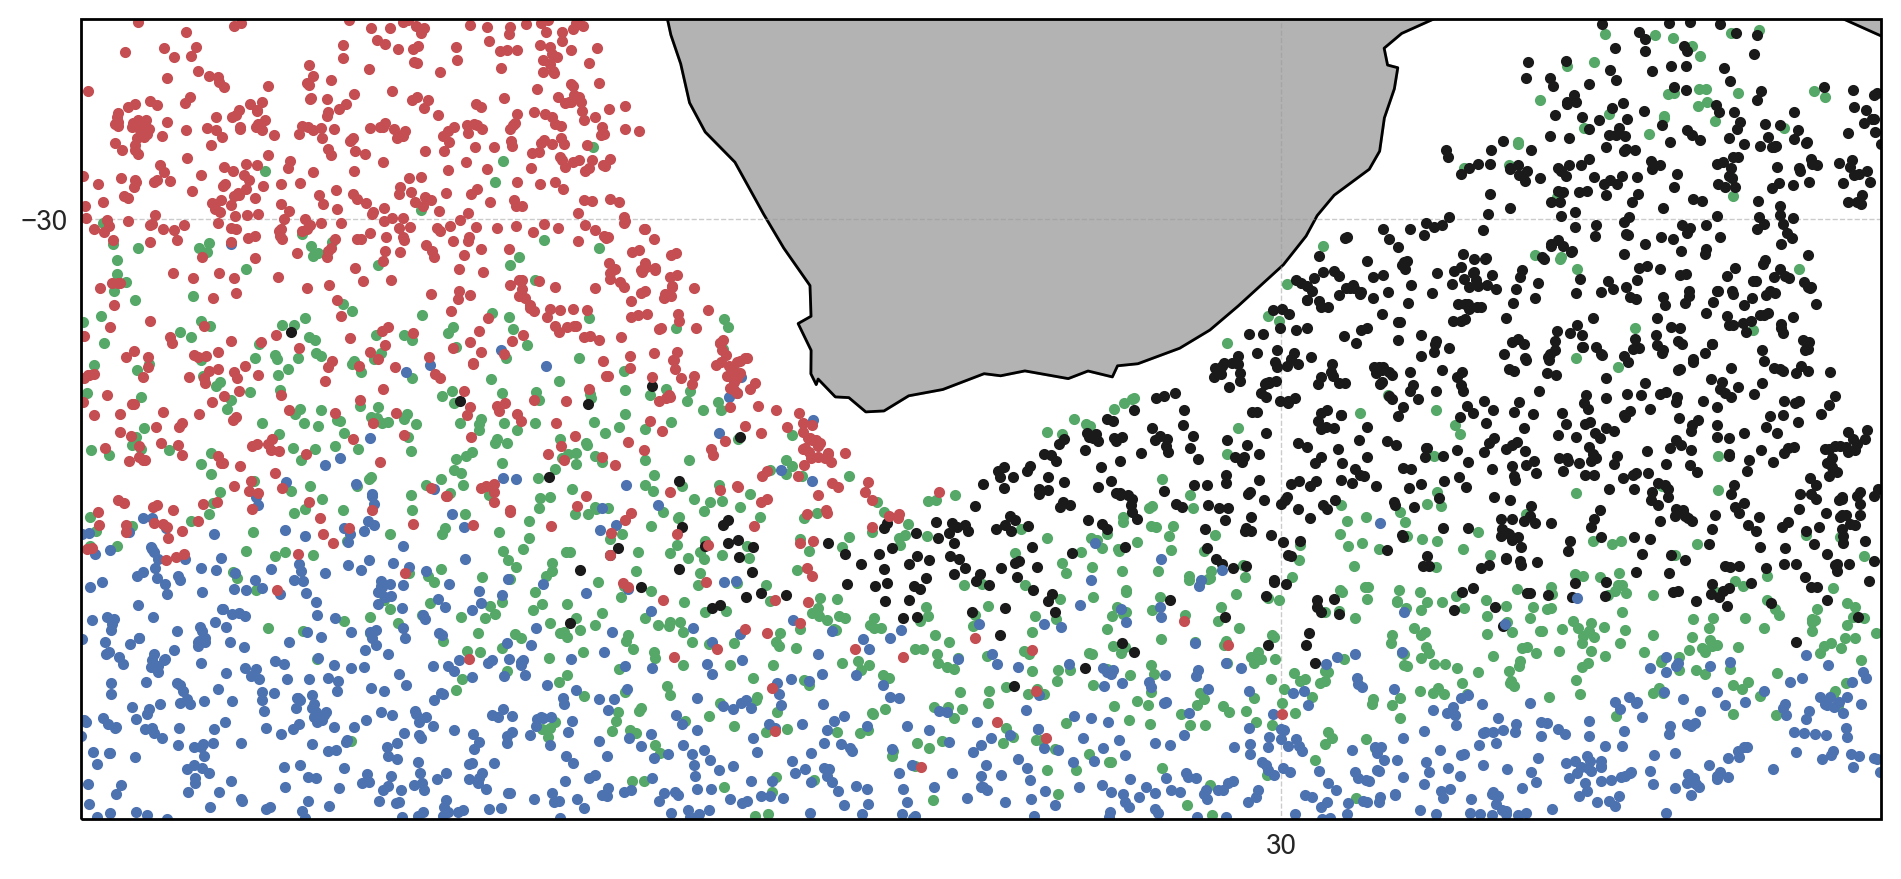

In [121]:
# création de la carte zoomée sur le bon endroit -- dans la definition de la fonction crate_map
fig, proj, ax = create_map()

plt.plot(lon0, lat0,'g.') #cmap=plt.cm.get_cmap('gist_ncar',10))
plt.plot(lon1, lat1,'k.') #cmap=plt.cm.get_cmap('gist_ncar',10))
plt.plot(lon2, lat2,'b.') #cmap=plt.cm.get_cmap('gist_ncar',10))
plt.plot(lon3, lat3,'r.')


In [17]:
# Maintenant qu'on a ça, ce qui serai chouette serai de comparer à une carte de temperature de surface pour regarder 
# si les pts rouges à gauche du cap de bonne esperance sont bien des tourbillons (aux bonnes dates bien entendu). 